In [1]:
import requests
import pandas as pd
import numpy as np
import datetime

# 让表格显示得更全
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

In [3]:
spacex_url = "https://api.spacexdata.com/v4/launches/past"

try:
    response = requests.get(spacex_url, timeout=20) # 增加超时等待时间
    if response.status_code == 200:
        data = pd.json_normalize(response.json())
        print("官方 API 连接成功！数据已加载。")
        print(f"数据量：{data.shape}")
        print(data.head(2))
    else:
        print(f"连接失败，错误代码: {response.status_code}")
except Exception as e:
    print(f"发生网络错误: {e}")
    print("\n--- 补救方案 ---")
    print("如果依然失败，请尝试在浏览器中直接打开链接下载并保存：")
    print(spacex_url)

官方 API 连接成功！数据已加载。
数据量：(187, 43)
       static_fire_date_utc  static_fire_date_unix    net  window  \
0  2006-03-17T00:00:00.000Z           1.142554e+09  False     0.0   
1                      None                    NaN  False     0.0   

                     rocket success  \
0  5e9d0d95eda69955f709d1eb   False   
1  5e9d0d95eda69955f709d1eb   False   

                                                                                                  failures  \
0                                      [{'time': 33, 'altitude': None, 'reason': 'merlin engine failure'}]   
1  [{'time': 301, 'altitude': 289, 'reason': 'harmonic oscillation leading to premature engine shutdown'}]   

                                                                                                                                                                                details  \
0                                                                                                                          

In [4]:
# 获取火箭版本（我们只需要 Falcon 9）
def getBoosterVersion(data):
    for x in data['rocket']:
       if x:
        response = requests.get("https://api.spacexdata.com/v4/rockets/"+str(x)).json()
        BoosterVersion.append(response['name'])

# 获取发射场信息（名称、经纬度）
def getLaunchSite(data):
    for x in data['launchpad']:
       if x:
         response = requests.get("https://api.spacexdata.com/v4/launchpads/"+str(x)).json()
         Longitude.append(response['longitude'])
         Latitude.append(response['latitude'])
         LaunchSite.append(response['name'])

# 获取载荷信息（重量、轨道）
def getPayloadData(data):
    for load in data['payloads']:
       if load:
        response = requests.get("https://api.spacexdata.com/v4/payloads/"+load[0]).json()
        PayloadMass.append(response['mass_kg'])
        Orbit.append(response['orbit'])

# 获取核心级信息（是否重复使用、着陆情况等）
def getCoreData(data):
    for core in data['cores']:
            if core['core'] != None:
                response = requests.get("https://api.spacexdata.com/v4/cores/"+core['core']).json()
                Block.append(response['block'])
                ReusedCount.append(response['reuse_count'])
                Serial.append(response['serial'])
            else:
                Block.append(None)
                ReusedCount.append(None)
                Serial.append(None)
            Outcome.append(str(core['landing_success'])+' '+str(core['landing_type']))
            Flights.append(core['flight'])
            GridFins.append(core['gridfins'])
            Reused.append(core['reused'])
            Legs.append(core['legs'])
            LandingPad.append(core['landingpad'])

In [6]:
# 1. 直接下载处理好的数据集（这是 API 调用后的结果）
data_url = "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-DS0321EN-SkillsNetwork/datasets/dataset_part_1.csv"
df = pd.read_csv(data_url)

# 2. 看看数据（这就是你刚才辛苦调用 API 想得到的样子）
print(df.head())

# 3. 检查一下有没有缺失值
print(df.isnull().sum())

   FlightNumber        Date BoosterVersion  PayloadMass Orbit    LaunchSite  \
0             1  2010-06-04       Falcon 9  6104.959412   LEO  CCAFS SLC 40   
1             2  2012-05-22       Falcon 9   525.000000   LEO  CCAFS SLC 40   
2             3  2013-03-01       Falcon 9   677.000000   ISS  CCAFS SLC 40   
3             4  2013-09-29       Falcon 9   500.000000    PO   VAFB SLC 4E   
4             5  2013-12-03       Falcon 9  3170.000000   GTO  CCAFS SLC 40   

       Outcome  Flights  GridFins  Reused   Legs LandingPad  Block  \
0    None None        1     False   False  False        NaN    1.0   
1    None None        1     False   False  False        NaN    1.0   
2    None None        1     False   False  False        NaN    1.0   
3  False Ocean        1     False   False  False        NaN    1.0   
4    None None        1     False   False  False        NaN    1.0   

   ReusedCount Serial   Longitude   Latitude  
0            0  B0003  -80.577366  28.561857  
1         

In [7]:
# 1. 计算载荷重量的平均值
avg_payload = df['PayloadMass'].mean()

# 2. 用平均值替换 NaN 值 (虽然你的数据目前显示是0个缺失，但这是标准操作)
df['PayloadMass'] = df['PayloadMass'].replace(np.nan, avg_payload)

# 3. 再次确认是否还有缺失值（除了 LandingPad）
print(df.isnull().sum())

FlightNumber       0
Date               0
BoosterVersion     0
PayloadMass        0
Orbit              0
LaunchSite         0
Outcome            0
Flights            0
GridFins           0
Reused             0
Legs               0
LandingPad        26
Block              0
ReusedCount        0
Serial             0
Longitude          0
Latitude           0
dtype: int64


In [8]:
# 将处理好的数据导出为 CSV
df.to_csv("dataset_part_1.csv", index=False)
print("文件 dataset_part_1.csv 已成功保存！")

文件 dataset_part_1.csv 已成功保存！


In [12]:
# 直接加载已经爬取并初步整理好的维基百科数据
web_data_url = "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-DS0321EN-SkillsNetwork/datasets/dataset_part_2.csv"
df_scraped = pd.read_csv(web_data_url)

print("已成功加载爬虫阶段备份数据！")
print(df_scraped.head())

已成功加载爬虫阶段备份数据！
   FlightNumber        Date BoosterVersion  PayloadMass Orbit    LaunchSite  \
0             1  2010-06-04       Falcon 9  6104.959412   LEO  CCAFS SLC 40   
1             2  2012-05-22       Falcon 9   525.000000   LEO  CCAFS SLC 40   
2             3  2013-03-01       Falcon 9   677.000000   ISS  CCAFS SLC 40   
3             4  2013-09-29       Falcon 9   500.000000    PO   VAFB SLC 4E   
4             5  2013-12-03       Falcon 9  3170.000000   GTO  CCAFS SLC 40   

       Outcome  Flights  GridFins  Reused   Legs LandingPad  Block  \
0    None None        1     False   False  False        NaN    1.0   
1    None None        1     False   False  False        NaN    1.0   
2    None None        1     False   False  False        NaN    1.0   
3  False Ocean        1     False   False  False        NaN    1.0   
4    None None        1     False   False  False        NaN    1.0   

   ReusedCount Serial   Longitude   Latitude  Class  
0            0  B0003  -80.577366  

In [13]:
# 查看 Outcome 列的种类及其出现的次数
landing_outcomes = df['Outcome'].value_counts()
print(landing_outcomes)

Outcome
True ASDS      41
None None      19
True RTLS      14
False ASDS      6
True Ocean      5
False Ocean     2
None ASDS       2
False RTLS      1
Name: count, dtype: int64


In [14]:
# 1. 定义成功的标签集合
bad_outcomes = set(landing_outcomes.keys()[[1, 3, 5, 6, 7]]) # 这是一个示例，取决于你的具体顺序
# 更保险的方法是直接写逻辑：
# 成功的：True ASDS, True RTLS, True Ocean
# 失败的：False ASDS, False RTLS, False Ocean, None ASDS, None None

# 2. 创建一个名为 Class 的空列表
landing_class = []

# 3. 遍历 Outcome 列，将成功设为 1，失败设为 0
for outcome in df['Outcome']:
    if 'True' in outcome:
        landing_class.append(1)
    else:
        landing_class.append(0)

# 4. 将这个列表添加回 DataFrame 作为一个新列
df['Class'] = landing_class

# 5. 检查前 5 行，看看 Class 列是否正确生成了
print(df[['Outcome', 'Class']].head(10))

       Outcome  Class
0    None None      0
1    None None      0
2    None None      0
3  False Ocean      0
4    None None      0
5    None None      0
6   True Ocean      1
7   True Ocean      1
8    None None      0
9    None None      0


In [15]:
success_rate = df['Class'].mean()
print(f"总体回收成功率: {success_rate:.2%}")

总体回收成功率: 66.67%


In [16]:
df.to_csv("dataset_part_2.csv", index=False)
print("Task 1.7 完成！dataset_part_2.csv 已保存。")

Task 1.7 完成！dataset_part_2.csv 已保存。


In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 加载我们刚才保存的数据
df = pd.read_csv("dataset_part_2.csv")

# 设置绘图风格
sns.set_theme(style="whitegrid")

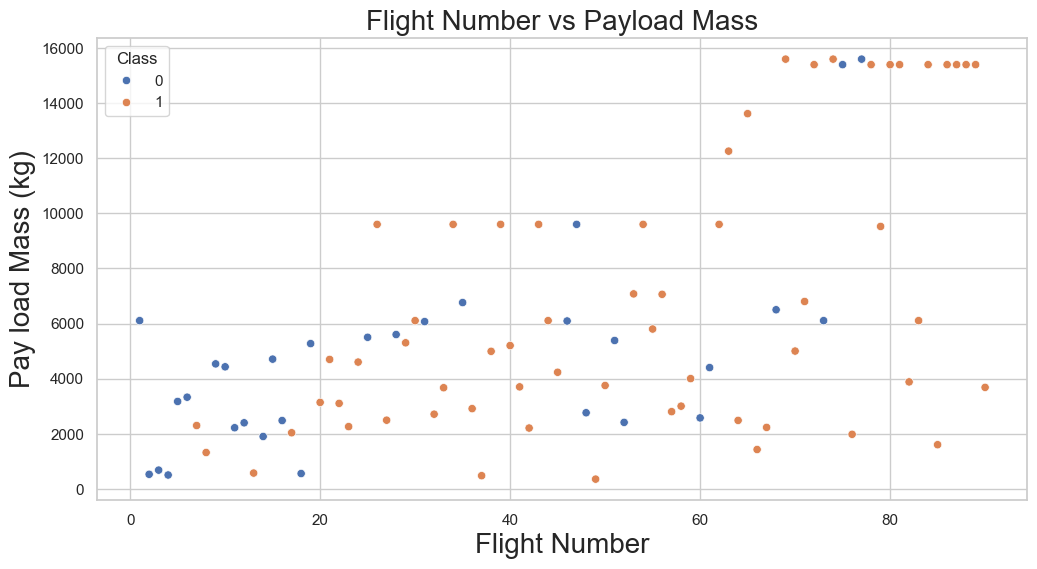

In [18]:
plt.figure(figsize=(12,6))
sns.scatterplot(y="PayloadMass", x="FlightNumber", hue="Class", data=df)
plt.xlabel("Flight Number", fontsize=20)
plt.ylabel("Pay load Mass (kg)", fontsize=20)
plt.title("Flight Number vs Payload Mass", fontsize=20)
plt.show()

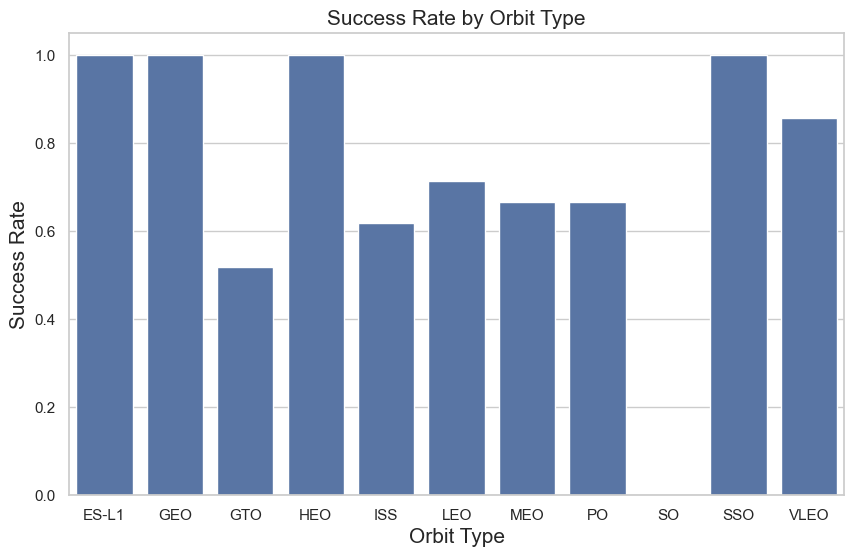

In [19]:
# 按轨道分组并计算 Class 的平均值（即成功率）
df_orbit = df.groupby('Orbit')['Class'].mean().reset_index()

plt.figure(figsize=(10,6))
sns.barplot(x="Orbit", y="Class", data=df_orbit)
plt.xlabel("Orbit Type", fontsize=15)
plt.ylabel("Success Rate", fontsize=15)
plt.title("Success Rate by Orbit Type", fontsize=15)
plt.show()

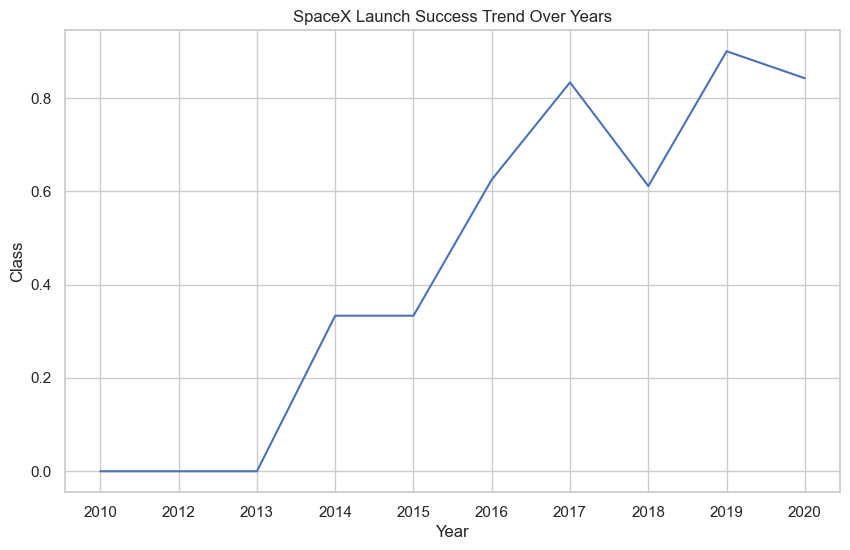

In [20]:
# 提取年份的辅助函数
def get_year(date_list):
    return [i.split("-")[0] for i in date_list]

df['Year'] = get_year(df['Date'])
df_year = df.groupby('Year')['Class'].mean().reset_index()

plt.figure(figsize=(10,6))
sns.lineplot(x="Year", y="Class", data=df_year)
plt.title("SpaceX Launch Success Trend Over Years")
plt.show()

In [21]:
import sqlite3
import pandas as pd

# 1. 连接到 SQLite 数据库（如果不存在则自动创建）
con = sqlite3.connect("my_data_sqlite.db")
cur = con.cursor()

# 2. 将之前清洗好的 df 加载到 SQL 表中，表名设为 SPACEXTBL
df.to_sql("SPACEXTBL", con, if_exists='replace', index=False, method="multi")

print("SQL 环境准备就绪！表 SPACEXTBL 已创建。")

SQL 环境准备就绪！表 SPACEXTBL 已创建。


In [22]:
query1 = "SELECT DISTINCT LaunchSite FROM SPACEXTBL"
df_res1 = pd.read_sql_query(query1, con)
print(df_res1)

     LaunchSite
0  CCAFS SLC 40
1   VAFB SLC 4E
2    KSC LC 39A


In [23]:
query2 = "SELECT * FROM SPACEXTBL WHERE LaunchSite LIKE 'CCA%' LIMIT 5"
df_res2 = pd.read_sql_query(query2, con)
print(df_res2)

   FlightNumber        Date BoosterVersion  PayloadMass Orbit    LaunchSite  \
0             1  2010-06-04       Falcon 9  6104.959412   LEO  CCAFS SLC 40   
1             2  2012-05-22       Falcon 9   525.000000   LEO  CCAFS SLC 40   
2             3  2013-03-01       Falcon 9   677.000000   ISS  CCAFS SLC 40   
3             5  2013-12-03       Falcon 9  3170.000000   GTO  CCAFS SLC 40   
4             6  2014-01-06       Falcon 9  3325.000000   GTO  CCAFS SLC 40   

     Outcome  Flights  GridFins  Reused  Legs LandingPad  Block  ReusedCount  \
0  None None        1         0       0     0       None    1.0            0   
1  None None        1         0       0     0       None    1.0            0   
2  None None        1         0       0     0       None    1.0            0   
3  None None        1         0       0     0       None    1.0            0   
4  None None        1         0       0     0       None    1.0            0   

  Serial  Longitude   Latitude  Class  Year 

In [24]:
query3 = "SELECT AVG(PayloadMass) FROM SPACEXTBL"
df_res3 = pd.read_sql_query(query3, con)
print(f"所有任务的平均载荷: {df_res3.values[0][0]} kg")

所有任务的平均载荷: 6104.959411764707 kg


In [25]:
query4 = """
SELECT Serial, COUNT(Class) as Success_Count 
FROM SPACEXTBL 
WHERE Class = 1 
GROUP BY Serial 
ORDER BY Success_Count DESC 
LIMIT 5
"""
df_res4 = pd.read_sql_query(query4, con)
print(df_res4)

  Serial  Success_Count
0  B1049              6
1  B1051              5
2  B1059              4
3  B1060              3
4  B1058              3


In [27]:
# 如果没安装，请取消下面一行的注释运行
!pip install folium

import folium
import pandas as pd

# 加载数据
df = pd.read_csv("dataset_part_2.csv")

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
     ---------------------------------------- 0.0/113.4 kB ? eta -:--:--
     --- ------------------------------------ 10.2/113.4 kB ? eta -:--:--
     --- ------------------------------------ 10.2/113.4 kB ? eta -:--:--
     ---------- -------------------------- 30.7/113.4 kB 163.8 kB/s eta 0:00:01
     ---------- -------------------------- 30.7/113.4 kB 163.8 kB/s eta 0:00:01
     ------------- ----------------------- 41.0/113.4 kB 140.3 kB/s eta 0:00:01
     ------------- ----------------------- 41.0/113.4 kB 140.3 kB/s eta 0:00:01
     -------------------- ---------------- 61.4/113.4 kB 182.2 kB/s eta 0:00:01
     -------------------- ---------------- 61.4/113.4 kB 182.2 kB/s eta 0:00:01
     ----------------------- ------------- 71.7/113.4 kB 163.8 kB/s eta 0:00:01
     ----------------------- ------------- 71.7/113.4 kB 163.8 kB/s eta 0:00:01
     ------------------------------ ------ 92.2/113.4 kB 169.3 kB/s eta 0:00:0


[notice] A new release of pip is available: 23.2.1 -> 26.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [28]:
# 1. 创建一个以美国中心为坐标的地图
site_map = folium.Map(location=[28.5721, -80.648], zoom_start=5)

# 2. 提取唯一的发射场及其经纬度
launch_sites_df = df.groupby(['LaunchSite'], as_index=False).first()
launch_sites_df = launch_sites_df[['LaunchSite', 'Latitude', 'Longitude']]

# 3. 循环添加标记
for index, site in launch_sites_df.iterrows():
    circle = folium.Circle([site['Latitude'], site['Longitude']], radius=1000, color='#d35400', fill=True).add_child(folium.Popup(site['LaunchSite']))
    marker = folium.Marker(
        [site['Latitude'], site['Longitude']],
        icon=folium.DivIcon(
            icon_size=(20,20),
            icon_anchor=(0,0),
            html='<div style="font-size: 12; color:#d35400;"><b>%s</b></div>' % site['LaunchSite'],
        )
    )
    site_map.add_child(circle)
    site_map.add_child(marker)

site_map

In [29]:
from folium.plugins import MarkerCluster

# 1. 创建标记集群对象
marker_cluster = MarkerCluster()
site_map.add_child(marker_cluster)

# 2. 定义颜色函数
def assign_marker_color(launch_outcome):
    if launch_outcome == 1:
        return 'green'
    else:
        return 'red'

df['marker_color'] = df['Class'].apply(assign_marker_color)

# 3. 将每次发射作为一个标记加入集群
for index, record in df.iterrows():
    marker = folium.Marker([record['Latitude'], record['Longitude']], 
                           icon=folium.Icon(color='white', icon_color=record['marker_color']))
    marker_cluster.add_child(marker)

site_map

In [30]:
# !pip install dash
import dash
from dash import dcc, html
from dash.dependencies import Input, Output
import plotly.express as px
import pandas as pd

# 加载数据
df = pd.read_csv("dataset_part_2.csv")

In [31]:
# !pip install dash
import dash
from dash import dcc, html
from dash.dependencies import Input, Output
import plotly.express as px
import pandas as pd

# 加载数据
df = pd.read_csv("dataset_part_2.csv")

In [34]:
from dash import Dash

app = Dash(__name__)

# 1. 布局：添加标题、下拉菜单和图表占位符
app.layout = html.Div(children=[
    html.H1('SpaceX Launch Records Dashboard',
            style={'textAlign': 'center', 'color': '#503D36', 'font-size': 40}),
    
    # 任务 1: 发射场选择下拉菜单
    dcc.Dropdown(id='site-dropdown',
                 options=[
                     {'label': 'All Sites', 'value': 'ALL'},
                     {'label': 'CCAFS SLC-40', 'value': 'CCAFS SLC-40'},
                     {'label': 'VAFB SLC-4E', 'value': 'VAFB SLC-4E'},
                     {'label': 'KSC LC-39A', 'value': 'KSC LC-39A'},
                     {'label': 'CCAFS LC-40', 'value': 'CCAFS LC-40'},
                 ],
                 value='ALL',
                 placeholder="Select a Launch Site here",
                 searchable=True
                 ),
    html.Br(),

    # 任务 2: 成功率饼图
    html.Div(dcc.Graph(id='success-pie-chart')),
    html.Br(),

    html.P("Payload range (Kg):"),
    # 任务 3: 载荷范围滑块
    dcc.RangeSlider(id='payload-slider',
                    min=0, max=10000, step=1000,
                    marks={0: '0', 10000: '10000'},
                    value=[0, 10000]),

    # 任务 4: 载荷与成功的散点图
    html.Div(dcc.Graph(id='success-payload-scatter-chart')),
])

# 2. 回调函数：根据下拉菜单更新饼图
@app.callback(Output(component_id='success-pie-chart', component_property='figure'),
              Input(component_id='site-dropdown', component_property='value'))
def get_pie_chart(entered_site):
    filtered_df = df
    if entered_site == 'ALL':
        fig = px.pie(filtered_df, values='Class', 
                     names='LaunchSite', 
                     title='Total Success Launches By Site')
        return fig
    else:
        # 针对特定场地的成功/失败统计
        site_df = df[df['LaunchSite'] == entered_site]
        success_count = site_df['Class'].value_counts().reset_index()
        success_count.columns = ['Class', 'count']
        fig = px.pie(success_count, values='count', 
                     names='Class', 
                     title=f'Total Success Launches for site {entered_site}')
        return fig
# 任务 4: 回调函数 - 根据下拉菜单和滑块更新散点图
@app.callback(Output(component_id='success-payload-scatter-chart', component_property='figure'),
              [Input(component_id='site-dropdown', component_property='value'), 
               Input(component_id='payload-slider', component_property='value')])
def get_scatter_chart(entered_site, payload_range):
    low, high = payload_range
    mask = (df['PayloadMass'] > low) & (df['PayloadMass'] < high)
    filtered_df = df[mask]
    
    if entered_site == 'ALL':
        fig = px.scatter(filtered_df, x="PayloadMass", y="Class", 
                         color="BoosterVersion",
                         title='Correlation between Payload and Success for all Sites')
        return fig
    else:
        site_df = filtered_df[filtered_df['LaunchSite'] == entered_site]
        fig = px.scatter(site_df, x="PayloadMass", y="Class", 
                         color="BoosterVersion",
                         title=f'Correlation between Payload and Success for site {entered_site}')
        return fig

# 运行应用
if __name__ == '__main__':
    # jupyter_mode="external" 会给你一个链接，点击在浏览器新窗口打开
    app.run(jupyter_mode="external")

Dash app running on http://127.0.0.1:8050/


In [35]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

# 1. 准备标签 Y
Y = df['Class'].to_numpy()

# 2. 准备特征 X
# 我们只选择对预测有意义的列
features = df[['FlightNumber', 'PayloadMass', 'Orbit', 'LaunchSite', 'Flights', 'GridFins', 'Reused', 'Legs', 'LandingPad', 'Block', 'ReusedCount', 'Serial']]

# 3. 对分类变量进行 One-Hot 编码 (关键步骤！)
X = pd.get_dummies(features)

# 4. 数据标准化 (Standardization)
# 这一步能让所有数字都在同一个量级，对 SVM 和 KNN 非常重要
transform = preprocessing.StandardScaler()
X = transform.fit_transform(X)

# 5. 拆分训练集和测试集 (80/20 分)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=2)

print(f"训练集样本量: {Y_train.shape[0]}")
print(f"测试集样本量: {Y_test.shape[0]}")

训练集样本量: 72
测试集样本量: 18


In [36]:
parameters = {"C":[0.01, 0.1, 1], 'penalty':['l2'], 'solver':['lbfgs']}
lr = LogisticRegression()

# 自动寻找最佳参数
logreg_cv = GridSearchCV(lr, parameters, cv=10)
logreg_cv.fit(X_train, Y_train)

print("最佳参数: ", logreg_cv.best_params_)
print("准确率 (accuracy): ", logreg_cv.best_score_)

最佳参数:  {'C': 1, 'penalty': 'l2', 'solver': 'lbfgs'}
准确率 (accuracy):  0.8214285714285714


In [37]:
parameters_svm = {'kernel':('linear', 'rbf','poly','rbf', 'sigmoid'),
              'C': np.logspace(-3, 3, 5),
              'gamma':np.logspace(-3, 3, 5)}
svm = SVC()

svm_cv = GridSearchCV(svm, parameters_svm, cv=10)
svm_cv.fit(X_train, Y_train)

print("SVM 最佳参数: ", svm_cv.best_params_)
print("SVM 准确率: ", svm_cv.best_score_)

SVM 最佳参数:  {'C': np.float64(1.0), 'gamma': np.float64(0.03162277660168379), 'kernel': 'sigmoid'}
SVM 准确率:  0.8482142857142858


In [38]:
parameters_tree = {'criterion': ['gini', 'entropy'],
     'splitter': ['best', 'random'],
     'max_depth': [2*n for n in range(1,10)],
     'max_features': ['auto', 'sqrt'],
     'min_samples_leaf': [1, 2, 4],
     'min_samples_split': [2, 5, 10]}

tree = DecisionTreeClassifier()

tree_cv = GridSearchCV(tree, parameters_tree, cv=10)
tree_cv.fit(X_train, Y_train)

print("决策树 最佳参数: ", tree_cv.best_params_)
print("决策树 准确率: ", tree_cv.best_score_)

决策树 最佳参数:  {'criterion': 'entropy', 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 10, 'splitter': 'random'}
决策树 准确率:  0.8892857142857145


D:\Graduation_Thesis\.venv\lib\site-packages\sklearn\model_selection\_validation.py:528: FitFailedWarning:


3240 fits failed out of a total of 6480.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3240 fits failed with the following error:
Traceback (most recent call last):
  File "D:\Graduation_Thesis\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Graduation_Thesis\.venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "D:\Graduation_Thesis\.venv\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "D:\Graduation_Thesis\.venv\l

In [39]:
parameters_knn = {'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
              'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
              'p': [1,2]}

KNN = KNeighborsClassifier()

knn_cv = GridSearchCV(KNN, parameters_knn, cv=10)
knn_cv.fit(X_train, Y_train)

print("KNN 最佳参数: ", knn_cv.best_params_)
print("KNN 准确率: ", knn_cv.best_score_)

KNN 最佳参数:  {'algorithm': 'auto', 'n_neighbors': 6, 'p': 1}
KNN 准确率:  0.8339285714285714


表现最好的模型是: Decision Tree, 准确率为: 0.8888888888888888


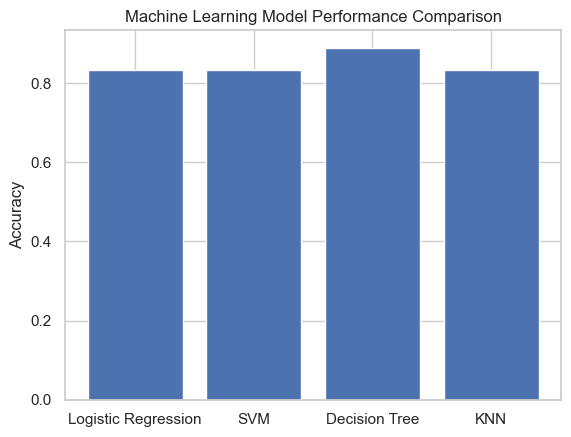

In [40]:
# 1. 比较四个模型在测试集上的表现
models = {'Logistic Regression': logreg_cv.score(X_test, Y_test),
          'SVM': svm_cv.score(X_test, Y_test),
          'Decision Tree': tree_cv.score(X_test, Y_test),
          'KNN': knn_cv.score(X_test, Y_test)}

best_model = max(models, key=models.get)
print(f"表现最好的模型是: {best_model}, 准确率为: {models[best_model]}")

# 2. 画出模型对比条形图
plt.bar(models.keys(), models.values())
plt.ylabel('Accuracy')
plt.title('Machine Learning Model Performance Comparison')
plt.show()

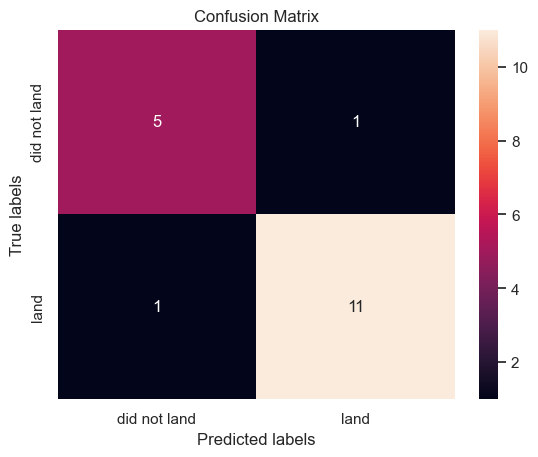

In [41]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

def plot_confusion_matrix(y,y_predict):
    cm = confusion_matrix(y, y_predict)
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax); 
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_title('Confusion Matrix'); 
    ax.xaxis.set_ticklabels(['did not land', 'land']); ax.yaxis.set_ticklabels(['did not land', 'land'])

yhat = tree_cv.predict(X_test)
plot_confusion_matrix(Y_test, yhat)